In [2]:
import numpy as np
import scipy as sp
from sdme_logloss import *

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# First we generate some stimulus:
stim_dim = 16*16
stim_len = 50000
stim = np.random.randn(stim_dim, stim_len)

In [4]:
# Next, we generate (first order) population receptive fields

N = 4  # Number of neurons
p=0.1
fo_rf = np.ones((N, stim_dim))
fo_rf[np.random.rand(N, stim_dim) > p] = 0

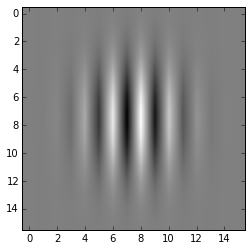

In [5]:
# Generate Second Order Receptive fields

x = np.linspace(-1.0, 1.0, 16)
y = x
X, Y = np.meshgrid(x, y)
gb = np.exp(-(X**2 + Y**2)/0.25)*np.sin(2*np.pi*4*X)
plt.figure()
plt.set_cmap('gray')
plt.imshow(gb)

gbvec = np.squeeze(np.reshape(gb, (stim_dim, 1)))
eigvecmat = np.random.randn(stim_dim, stim_dim)
eigvecmat[0, :] = gbvec
eigvalmat = np.identity(stim_dim)/10.0
eigvalmat[0,0] = 1.0
stc_model = np.dot(np.linalg.inv(eigvecmat), np.dot(eigvalmat, eigvecmat))
stc_model_cube = np.zeros((N, stim_dim, stim_dim))
stc_model_cube[0, :, :] = stc_model



In [6]:
# Generate matrix of all possible population states
nstates = 2**N
stvec = range(nstates)
stmat = np.tile(stvec, (N, 1))
for rw in range(N):
    stmat[rw, :] = np.mod(stmat[rw, :]/(2**rw), 2)


In [7]:
# Next, we generate correlations between the neurons
p2 = 0.5
neu_corr = np.ones((N, N))
neu_corr[np.random.rand(N, N) > p2] = 0
neu_corr = (neu_corr + np.transpose(neu_corr))/2.0 

In [8]:
# Compute the probability over states
outcorr = np.einsum('ijk,jt,kt->it', stc_model_cube, stim, stim)
corr_states = np.diag(np.dot(np.dot(np.transpose(stmat), neu_corr), stmat))

E = np.dot(np.dot(np.transpose(stmat),fo_rf),stim) + np.transpose(np.tile(corr_states, (stim_len, 1))) + np.dot(np.transpose(stmat), outcorr)
probs = np.exp(E) / np.sum(np.exp(E),0 )

In [10]:
# Sanity Check
np.sum(probs, 0)
np.amax(outcorr[0, :])

108.18093889809121

In [33]:
# Generate Responses
# cumulative probs
probs_c = np.concatenate((np.zeros((1, stim_len)), np.cumsum(probs, 0)), 0)

# generate random vec
nreps = 20


prb = np.random.rand(1, stim_len)
outcomes = 1*np.logical_and(probs_c[0:-1, :] < prb, probs_c[1:, :] > prb)
    #np.concatenate((outcomesav, outcomes))
pop_response = np.dot(stmat, outcomes)



In [35]:
# Compute estimates from model

#Neuron Covariance matrix
est_cov = np.dot(pop_response, np.transpose(pop_response)) / (1.0*stim_len)


# STAs
STA_est = np.tensordot(pop_response, np.transpose(stim), 1)/(1.0*stim_len)

#Cov
Cov_est = np.tensordot(pop_response, np.transpose(pop_response), 1) / (1.0*stim_len)



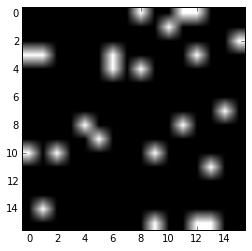

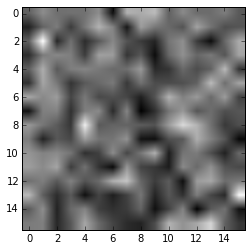

In [36]:
rf0_sq = np.reshape(fo_rf[0,:], (16, 16))
rf0_est_sq= np.reshape(STA_est[0,:], (16, 16))
cov_est_sq = np.reshape(Cov_est, (4, 4)) - np.identity(N)

plt.figure()
plt.imshow(rf0_sq)

plt.figure()
plt.imshow(rf0_est_sq)

#plt.figure()
#plt.imshow(neu_corr)
#plt.figure()
#plt.imshow(cov_est_sq)

In [37]:
def data_to_sta(spikes, stim):
    # sptimes: N x stimlen x nrepreats
    # stim: stimdim x stimlen
    N, stimlen, nreps = np.shape(spikes)
    print(np.shape(spikes))
    spikes = np.squeeze(np.sum(spikes, 2))
    print(np.shape(spikes))
    sta = np.tensordot(spikes, np.transpose(stim), 1)
    sta = sta / (1.0*nreps*stimlen)
    return sta

In [38]:
pop_response_rep = np.expand_dims(pop_response, 2)
test_sta = data_to_sta(pop_response_rep, stim)
np.shape(test_sta)

(4, 50000, 1)
(4, 50000)


(4, 256)

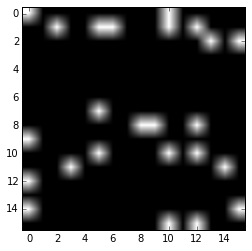

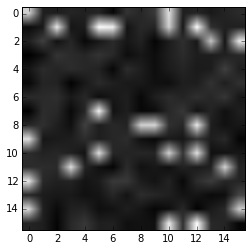

In [39]:
rf0_sq = np.reshape(fo_rf[1,:], (16, 16))
rf0_est_sq= np.reshape(test_sta[1,:], (16, 16))

plt.figure()
plt.imshow(rf0_sq)

plt.figure()
plt.imshow(rf0_est_sq)

In [40]:
def data_to_stc(spikes, stim):
    # spikes: N x stimlen x nrepeats
    # stim: stimdim x stimlen
    
    N, stimlen, nreps = np.shape(spikes)
    spikes = 1.0*np.squeeze(np.sum(spikes, 2))
    print(spikes)
    
    stim_outer_diag = np.einsum('ij,kj,lj->ikl', spikes,stim,stim)
    stc = stim_outer_diag / (1.0*nreps*stimlen)
    return stc

In [41]:
test_stc = data_to_stc(pop_response_rep, stim)
np.shape(test_stc)

[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  0.  1.]
 [ 1.  1.  1. ...,  1.  0.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


(4, 256, 256)

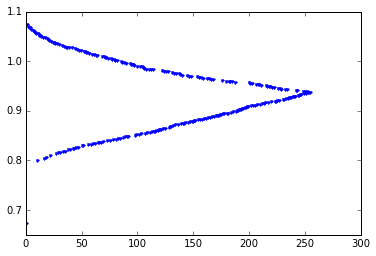

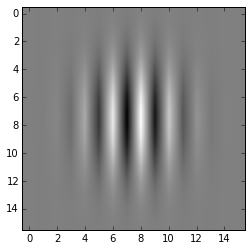

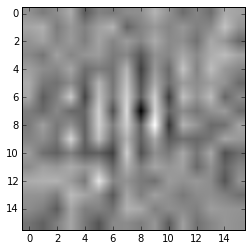

In [42]:
eigvals_0, eigvecs_0 = np.linalg.eig(test_stc[0, :, :])
plt.figure()
plt.plot(eigvals_0, '.')

eigvec_0_0_sq = np.reshape(eigvecs_0[:, 0], (16, 16))

plt.figure()
plt.imshow(gb)

plt.figure()
plt.imshow(eigvec_0_0_sq)